In [1]:
from sklearn.cluster import KMeans, DBSCAN
from datetime import datetime
from sklearn import metrics
from statistics import median
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import pickle
import math
import copy

## Preprocess Data

In [2]:
def preprocessing(file):
    """Method to handle the preparation of log event data for further usage in NLP learning methods.
    Timestamps are being changed to time inbetween events in a certain trace. After that the values are categorized to
    to further improve the quality of data"""
    
    # Convert the basic csv input into a first dataframe.
    df = pd.read_csv('../../logs/'+file, delimiter=';', header=None)
    df = df.drop([df.columns[3]], axis=1)
    df.columns = ['timestamp','id','event']
    
    # Converting timestamps to time difference between events in trace. Difference will be in seconds and categorized to
    # ease training of the model. First event will therefore always have a '0' value.
    
    FMT = '%Y-%m-%d %H:%M:%S' # timestamp format
    timediff_list = []

    for caseID in df['id'].unique():
        caseIndex = 0 # Index for each trace dataframe. iterrows() Index represents index in global DF.
        first_time = '' # Temp variable to hold the timestamp of the first event. Timestamp will be lost after first iteration.
        for index, event in df[df['id'] == caseID].iterrows():
            event_time = event['timestamp']
            
            if caseIndex == 0:
                first_time = event_time
                timediff_list.append(0.0) # Can't use previous time without previous event. Time differnece is therefore 0.0..
            elif caseIndex == 1:
                tdelta = datetime.strptime(event_time, FMT) - datetime.strptime(first_time, FMT) # Deduct current from from previous.
                timediff_list.append(tdelta.total_seconds())
            else: 
                prev_time = df[df['id'] == caseID].iloc[caseIndex-1]['timestamp'] # Timestamp of previous event.
                tdelta = datetime.strptime(event_time, FMT) - datetime.strptime(prev_time, FMT) # Deduct current from from previous.
                timediff_list.append(tdelta.total_seconds())
            caseIndex += 1
    
    # Converting the build up timediff_list into a DataFrame, categorizing it and replace the new values with the given timestamps.
    timediff_df = pd.DataFrame(timediff_list, columns=['timestamp_diff'])
    timediff_df = pd.cut(timediff_df['timestamp_diff'],10, labels=False) # Categorizing differences into 10 bins with same width.
    df = pd.concat([timediff_df,df.drop(['timestamp'], axis=1) ], axis=1, join='inner') # Dropping old timestamps and adding new
    df['event'] = df['event'].str.lower() # Converting string to lower case.
    
    # Converting dataframe values into strings and tokenize each event after.
    string_list = df.to_string(header=False,index=False,index_names=False).split('\n')
    token_list = [nltk.word_tokenize(event.lower()) for event in string_list] # List containing event tokens.
    
    # Creating a list containing word tokens for each trace ID.
    traceids = df['id'].unique()
    trace_list = []
    
    # Filter for each tradeid and convert each trade into lists, containing the events.
    for id in traceids:
        df_trace= df.loc[df['id']==id] # df holding the entries for the specific trace ID
        traceString = df_trace.to_string(header=False,index=False,index_names=False).split('\n') # Converting each event into a string
        traceToken = [nltk.word_tokenize(event.lower()) for event in traceString]

        trace_list.append(traceToken)
    
    return df, trace_list, token_list

In [3]:
df, traceToken, tokenList = preprocessing('ecommerce_anomalies.csv')

## Load and Train model with tokenized events

In [4]:
from gensim.models import Word2Vec, KeyedVectors

In [5]:
model = Word2Vec(sentences=tokenList, vector_size=300, window=4, min_count=1, workers=4)

In [6]:
model.wv.get_vector('to')

array([-0.02673793,  0.14288232, -0.03356295, -0.03957888, -0.04440643,
       -0.13179399,  0.02100468,  0.24896847, -0.02299388, -0.07527686,
        0.08792015, -0.08564857, -0.00855986,  0.10917463, -0.00143107,
       -0.10633812,  0.11117516, -0.03197224,  0.04941015, -0.11982159,
       -0.02351318, -0.0889549 ,  0.0278508 ,  0.09080572, -0.06627642,
        0.00409834, -0.1214076 ,  0.04111356, -0.09482418, -0.13410415,
        0.00344282, -0.03025531,  0.0841852 , -0.00883497, -0.01008335,
        0.04465526,  0.00300556, -0.10648863,  0.01084413,  0.0107187 ,
       -0.06504234, -0.0357751 ,  0.04094614, -0.06554902,  0.0817846 ,
        0.04034458, -0.0402892 , -0.03513351,  0.0127326 ,  0.07693516,
       -0.02431867,  0.05484161, -0.06814974,  0.12262839,  0.04720351,
        0.04747346, -0.02676942,  0.00469864,  0.0336825 , -0.02080724,
        0.02963458, -0.06131385, -0.01723009,  0.14741428,  0.00298499,
        0.06265487, -0.0178405 ,  0.07207933, -0.09363757,  0.06

In [7]:
# Create duplicate of traceToken holding the token vectors.
trace_VecWordList = copy.deepcopy(traceToken)
for trace in range(len(trace_VecWordList)):
    for event in range(len(trace_VecWordList[trace])):
        for token in range(len(trace_VecWordList[trace][event])):
            vec_temp = model.wv.get_vector(traceToken[trace][event][token])
            trace_VecWordList[trace][event][token] = vec_temp

## Building trace vectors

In [8]:
def build_traceVector(df, traceVectorList, traceWordList):
    """Method to process data created by word model. It will form a summed up vector for each trace and weigh in tokens with calculated IDF."""
    
    unique_tokens = set() # Will hold unique values for all columns. 
    
    unique_tokens.update(list(df['timestamp_diff'].map(str).unique()))
    unique_tokens.update(list(df['id'].map(str).unique()))
    unique_tokens.update(list(df['event'].str.lower().str.split(' ').sum()))
    
    idf_dict = dict.fromkeys(unique_tokens, 0) # Initiate dictionary holding all unique keys with 0 as values. 
    
    #Building up dictionary and upping the counter for every event which contains the word.
    for trace in traceWordList:
        for event in trace:
            for uniqueToken in unique_tokens:
                if uniqueToken in event:
                    idf_dict[uniqueToken] += 1
    
    # Calculating IDF with log of basis 10.
    event_len = len(df)
    for key in idf_dict:
        if idf_dict[key] != 0:
            idf_dict[key] = math.log10(event_len/(idf_dict[key]+1))
    
    # Building up list of IDF values for Case IDs and calculating the median. 
    unique_IDs = df['id'].unique() # automatically sorted 
    median_list = []
    
    for caseID in unique_IDs: 
        median_list.append(idf_dict[str(caseID)])
    median_case = median(median_list) # Represents the median idf score for the case IDs.
    
    # Update traceVectorList by multiplying items with the idf score. Case ID will be multiplied by idf-score/median_case.
    idfVectorList = copy.deepcopy(traceVectorList)
    for traceID in range(len(traceVectorList)): #Representing array index and not real trace IDs
        for eventID in range(len(traceVectorList[traceID])):
            event_list = [] # List in which the multiplied vectors of each event token are stored.
            for tokenID in range(len(traceVectorList[traceID][eventID])):
                
                if tokenID != 1: # Ignore case IDs
                    idf_val = idf_dict[traceWordList[traceID][eventID][tokenID]] # Holding idf value of current token.
                    word_vec = traceVectorList[traceID][eventID][tokenID] # The vector of current token.
                    multiplied_Vec = np.multiply(idf_val,word_vec)
                    event_list.append(multiplied_Vec)
                
            idfVectorList[traceID][eventID] = event_list # Add list of vectors to new list of multiplied values.
    
    # Instead of factoring in vector of case IDs we will take the trace length into account. It is more likely to have anomalies in traced with high deviation from median length.
    # After that we will sum up the event vectors and then trace vectors in the next step.
    idfSumList = copy.deepcopy(idfVectorList) # Will hold the summed up trace vectors.
    for traceIndex in range(len(idfVectorList)):
        median_difference = abs(median_case-idf_dict[str(unique_IDs[traceIndex])])+1 # Median minus the IDF of each case ID. Works because unique_IDs and traceVectorList are sorted..
        #print(f"Is multiplied by {median_difference}")
        for eventIndex in range(len(idfVectorList[traceIndex])):
            idf_EventList = np.multiply(median_difference,idfVectorList[traceIndex][eventIndex]) # Multiplying all vectos by the median difference.
            idfSumList[traceIndex][eventIndex] = np.add.reduce(idf_EventList) # Building the sum vector of the event vectors.
            
        idfSumList[traceIndex] = np.add.reduce(idfSumList[traceIndex])
            
    return idfSumList

In [9]:
traceList = build_traceVector(df, trace_VecWordList, traceToken)
df_traceList = pd.DataFrame(traceList)

## Clustering the data

KMeans

<AxesSubplot:xlabel='k', ylabel='Distortion'>

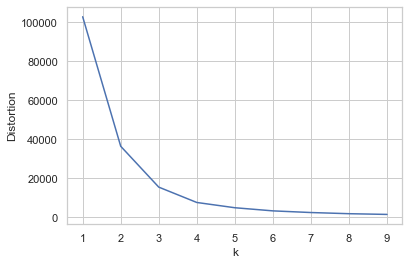

In [10]:
distortions = []
K = range(1,10)
for k in K: 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(traceList)
    distortions.append(kmeanModel.inertia_)

data_plot = pd.DataFrame({'k': K, 'Distortion': distortions})
sns.set_theme(style="whitegrid")
sns.lineplot(x="k", y="Distortion", data = data_plot)

In [11]:
kmeans = KMeans(n_clusters=5).fit(traceList)

In [12]:
df_traceList['kmeans_cluster'] = kmeans.predict(traceList)
kmeans.cluster_centers_ # Centers of determined clusters

array([[-0.25271206,  4.71674749, -1.17041507, ..., -0.58777672,
         1.30461465, -3.75214277],
       [-0.45477214,  6.9036304 , -1.71685753, ..., -0.74835807,
         1.90580623, -5.4728703 ],
       [-0.84992947, 11.08870043, -2.75331369, ..., -1.0630158 ,
         3.04562   , -8.77377326],
       [-0.34518345,  5.83523098, -1.45167856, ..., -0.66077526,
         1.60683735, -4.6205157 ],
       [-0.63051948,  8.55620859, -2.12248203, ..., -0.87996767,
         2.37106183, -6.79381028]])

DBScan

In [13]:
db = DBSCAN(eps=2.5, min_samples=10).fit(traceList)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

df_traceList['dbscan_cluster'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print(labels)

Estimated number of clusters: 2
Estimated number of noise points: 25


In [14]:
df_traceList.head()

0         1         2         3         4         5         6  \
0 -0.309933  5.049435 -1.258675 -1.928445 -0.985313 -4.436774  1.269172   
1 -0.229277  4.485329 -1.106553 -1.724466 -0.856298 -3.923925  1.154571   
2 -0.241541  4.609877 -1.136592 -1.778296 -0.870594 -4.047397  1.190188   
3 -0.302196  4.979954 -1.240414 -1.904761 -0.972469 -4.384271  1.271318   
4 -0.333338  6.261388 -1.566677 -2.418677 -1.191385 -5.413291  1.614995   

          7         8         9  ...       292       293       294       295  \
0  7.618143 -0.550839 -2.262546  ...  4.043974  1.764939  5.246995  4.671951   
1  6.683316 -0.476924 -1.962492  ...  3.578555  1.552903  4.614998  4.123612   
2  6.864396 -0.489917 -2.014639  ...  3.683338  1.609222  4.740243  4.242377   
3  7.513901 -0.542873 -2.227432  ...  3.995776  1.752500  5.172969  4.618423   
4  9.273130 -0.694831 -2.774982  ...  4.965257  2.186610  6.411633  5.791056   

        296       297       298       299  kmeans_cluster  dbscan_cluster  
0  0.099510 -0.605388  1.403941 -4.025003               0               0  
1  0.109939 -0.570161  1.245408 -3.562700               0               0  
2  0.096725 -0.584836  1.274903 -3.664516               0               0  
3  0.104396 -0.592999  1.379947 -3.962815               0               0  
4  0.076366 -0.715393  1.725339 -4.947263               3               0  

[5 rows x 302 columns]

In [15]:
trace_StrList = [] # Build list holding string for display in 3d Plot.
for trace in traceToken:
    traceStr = ""
    for event in trace:
        for word in event: 
            traceStr += word+' '
        traceStr += '<br>'
    trace_StrList.append(traceStr)

df_traceList['traceStr'] = trace_StrList

## Reducing dimensions

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### PCA

In [17]:
pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(df_traceList.drop(["kmeans_cluster","dbscan_cluster",'traceStr'], axis=1)))
PCs_2d.columns = ["PC1", "PC2"]

pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(df_traceList.drop(["kmeans_cluster","dbscan_cluster",'traceStr'], axis=1)))
PCs_3d.columns = ["PC1", "PC2","PC3"]

pca_4d = PCA(n_components=4)
PCs_4d = pd.DataFrame(pca_4d.fit_transform(df_traceList.drop(["kmeans_cluster","dbscan_cluster",'traceStr'], axis=1)))
PCs_4d.columns = ["PC1", "PC2","PC3","PC4"]

In [18]:
df_pca_2d = pd.concat([PCs_2d,df_traceList[["dbscan_cluster",'kmeans_cluster','traceStr']]], axis=1, join='inner')
df_pca_3d = pd.concat([PCs_3d,df_traceList[["dbscan_cluster",'kmeans_cluster','traceStr']]], axis=1, join='inner')
df_pca_4d = pd.concat([PCs_4d,df_traceList[["dbscan_cluster",'kmeans_cluster','traceStr']]], axis=1, join='inner')

### T-SNE

In [19]:
# Training data
pca_tsne = PCA(n_components=50).fit_transform(df_traceList.drop(["kmeans_cluster","dbscan_cluster",'traceStr'], axis=1))

tsne_2d_model = TSNE(n_components=2, perplexity = 100, random_state = 0, n_iter=10000)
df_tsne_2d = pd.DataFrame(data=tsne_2d_model.fit_transform(pca_tsne), columns=('TSNE1', 'TSNE2'))
df_tsne_2d = pd.concat([df_tsne_2d,df_traceList[["dbscan_cluster",'kmeans_cluster','traceStr']]], axis=1, join='inner') # Create df for plotting

tsne_3d_model = TSNE(n_components=3, perplexity = 50, random_state = 0)
df_tsne_3d = pd.DataFrame(data=tsne_3d_model.fit_transform(pca_tsne), columns=('TSNE1', 'TSNE2','TSNE3'))
df_tsne_3d = pd.concat([df_tsne_3d,df_traceList[["dbscan_cluster",'kmeans_cluster','traceStr']]], axis=1, join='inner')

C:\Users\nbloe\Documents\ba-eventlogml\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\nbloe\Documents\ba-eventlogml\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\nbloe\Documents\ba-eventlogml\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\nbloe\Documents\ba-eventlogml\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [20]:
df_tsne_3d.head()

TSNE1     TSNE2     TSNE3  dbscan_cluster  kmeans_cluster  \
0 -2.199116  3.428578 -7.720253               0               0   
1  7.069263 -6.009961  6.086350               0               0   
2  7.872365  0.465004  1.435749               0               0   
3 -1.732420  4.656081 -7.716113               0               0   
4 -5.193291 -4.648532 -0.712977               0               3   

                                            traceStr  
0  0 854 website request served <br>7 854 user lo...  
1  0 855 website request served <br>5 855 user lo...  
2  0 856 website request served <br>5 856 user lo...  
3  0 857 website request served <br>3 857 user lo...  
4  0 858 website request served <br>7 858 user lo...

## Visualizing the data

[Text(0.5, 1.0, 'T-SNE DBSCAN')]

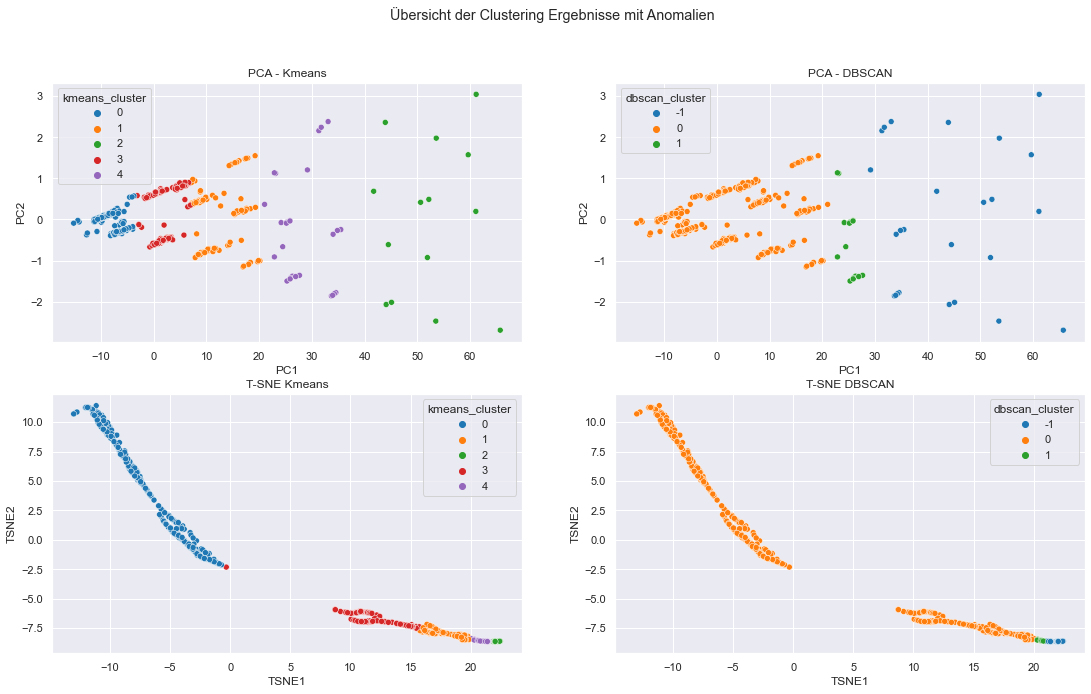

In [21]:
sns.set()
plot_2d_overview, axes = plt.subplots(2,2)
plot_2d_overview.suptitle('Übersicht der Clustering Ergebnisse mit Anomalien')
plot_2d_overview.set_size_inches(18.5, 10.5)


sns.scatterplot(x='PC1',y='PC2', data=df_pca_2d, hue='kmeans_cluster', palette='tab10', ax=axes[0,0]).set(title="PCA - Kmeans")
sns.scatterplot(x='PC1',y='PC2', data=df_pca_2d, hue='dbscan_cluster', palette='tab10', ax=axes[0,1]).set(title="PCA - DBSCAN")
sns.scatterplot(x='TSNE1',y='TSNE2', data=df_tsne_2d, hue='kmeans_cluster', palette='tab10', ax=axes[1,0]).set(title="T-SNE Kmeans")
sns.scatterplot(x='TSNE1',y='TSNE2', data=df_tsne_2d, hue='dbscan_cluster', palette='tab10', ax=axes[1,1]).set(title="T-SNE DBSCAN")

## 3D

PCA KMeans

In [22]:
import plotly as py
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [23]:
plot_3dscatter_3d_pca_kmeans = go.Figure()
clusters = df_pca_3d['kmeans_cluster'].unique() # Holding the unique cluster IDs

for cluster in clusters:
    plot_3dscatter_3d_pca_kmeans.add_trace(go.Scatter3d(
                    x = df_pca_3d[df_pca_3d['kmeans_cluster'] == cluster]["PC1"],
                    y = df_pca_3d[df_pca_3d['kmeans_cluster'] == cluster]["PC2"],
                    z = df_pca_3d[df_pca_3d['kmeans_cluster'] == cluster]["PC3"],
                    mode = "markers",
                    name = "Cluster "+str(cluster),
                    text = df_pca_3d[df_pca_3d['kmeans_cluster'] == cluster]['traceStr']))

plot_3dscatter_3d_pca_kmeans.update_layout(autosize = True, showlegend = True,title = 'Trace Clustering mit vortrainiertem Modell und KMeans - mit PCA reduziert - mit Anomalien',
                   scene = dict(xaxis=dict(title = 'PC1', titlefont_color = 'black'),
                                yaxis=dict(title = 'PC2', titlefont_color = 'black'),
                                zaxis=dict(title = 'PC3', titlefont_color = 'black')))

Text(0.5, 0.98, 'PCA 3D with KMeans Clusters and anomalies')

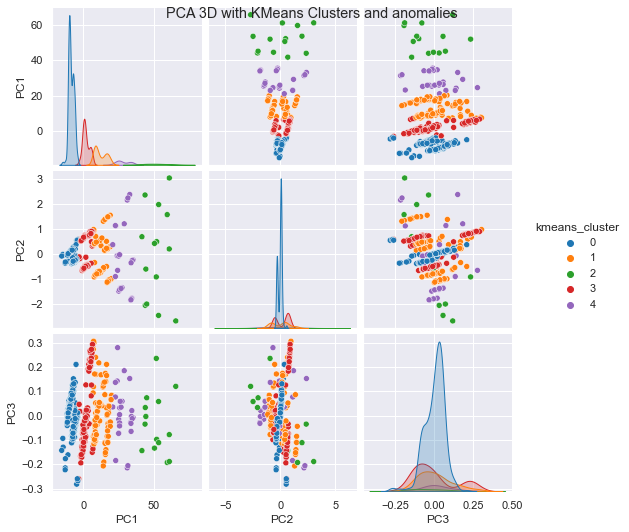

In [24]:
plot_scatter_3d_pca_kmeans = sns.pairplot(df_pca_3d.drop(['dbscan_cluster'], axis=1), hue='kmeans_cluster', palette='tab10')
plot_scatter_3d_pca_kmeans.fig.suptitle("PCA 3D with KMeans Clusters and anomalies")

PCA - DBSCAN

In [25]:
plot_3dscatter_3d_pca_dbscan = go.Figure()
clusters = df_pca_3d['dbscan_cluster'].unique() # Holding the unique cluster IDs

for cluster in clusters:
    plot_3dscatter_3d_pca_dbscan.add_trace(go.Scatter3d(
                    x = df_pca_3d[df_pca_3d['dbscan_cluster'] == cluster]["PC1"],
                    y = df_pca_3d[df_pca_3d['dbscan_cluster'] == cluster]["PC2"],
                    z = df_pca_3d[df_pca_3d['dbscan_cluster'] == cluster]["PC3"],
                    mode = "markers",
                    name = "Cluster "+str(cluster),
                    text = df_pca_3d[df_pca_3d['dbscan_cluster'] == cluster]['traceStr']))

plot_3dscatter_3d_pca_dbscan.update_layout(autosize = True, showlegend = True,title = 'Trace Clustering mit vortrainiertem Modell und DBSCAN - mit PCA reduziert - mit Anomalien',
                   scene = dict(xaxis=dict(title = 'PC1', titlefont_color = 'black'),
                                yaxis=dict(title = 'PC2', titlefont_color = 'black'),
                                zaxis=dict(title = 'PC3', titlefont_color = 'black')))

Text(0.5, 0.98, 'PCA 3D with DBSCAN Clusters and anomalies')

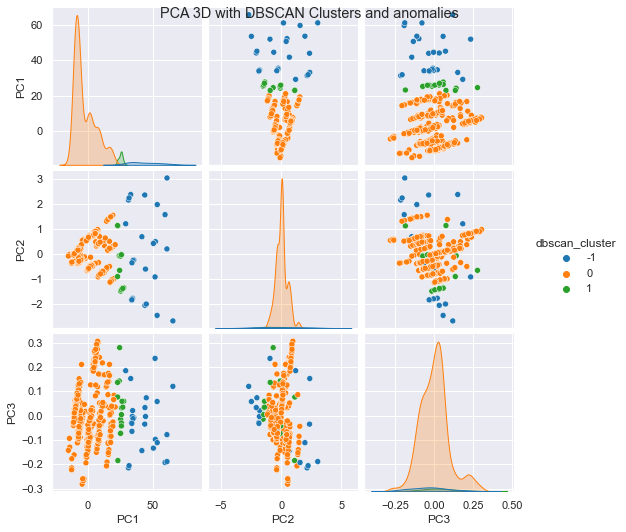

In [26]:
plot_scatter_3d_pca_dbscan = sns.pairplot(df_pca_3d.drop(['kmeans_cluster'], axis=1), hue='dbscan_cluster', palette='tab10')
plot_scatter_3d_pca_dbscan.fig.suptitle("PCA 3D with DBSCAN Clusters and anomalies")

T-SNE KMeans

In [27]:
plot_3dscatter_3d_tsne_kmeans = go.Figure()
clusters = df_tsne_3d['kmeans_cluster'].unique() # Holding the unique cluster IDs

for cluster in clusters:
    plot_3dscatter_3d_tsne_kmeans.add_trace(go.Scatter3d(
                    x = df_tsne_3d[df_tsne_3d['kmeans_cluster'] == cluster]["TSNE1"],
                    y = df_tsne_3d[df_tsne_3d['kmeans_cluster'] == cluster]["TSNE2"],
                    z = df_tsne_3d[df_tsne_3d['kmeans_cluster'] == cluster]["TSNE3"],
                    mode = "markers",
                    name = "Cluster "+str(cluster),
                    text = df_tsne_3d[df_tsne_3d['kmeans_cluster'] == cluster]['traceStr']))

plot_3dscatter_3d_tsne_kmeans.update_layout(autosize = True, showlegend = True,title = 'Trace Clustering mit vortrainiertem Modell und KMeans - mit T-SNE reduziert - mit Anomalien',
                   scene = dict(xaxis=dict(title = 'TSNE1', titlefont_color = 'black'),
                                yaxis=dict(title = 'TSNE2', titlefont_color = 'black'),
                                zaxis=dict(title = 'TSNE3', titlefont_color = 'black')))
#pio.write_html(PLOT,'./figs/pretrained/html/test.html')

Text(0.5, 0.98, 'T-SNE 3D with Kmeans Clusters and anomalies')

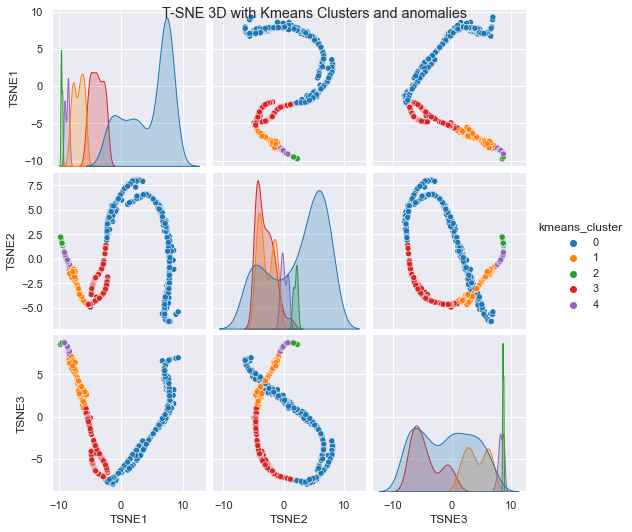

In [28]:
plot_scatter_3d_tsne_kmeans = sns.pairplot(df_tsne_3d.drop(['dbscan_cluster'], axis=1), hue='kmeans_cluster', palette='tab10')
plot_scatter_3d_tsne_kmeans.fig.suptitle("T-SNE 3D with Kmeans Clusters and anomalies")

T-SNE DBSCAN

In [29]:
plot_3dscatter_3d_tsne_dbscan = go.Figure()
clusters = df_tsne_3d['dbscan_cluster'].unique() # Holding the unique cluster IDs

for cluster in clusters:
    plot_3dscatter_3d_tsne_dbscan.add_trace(go.Scatter3d(
                    x = df_tsne_3d[df_tsne_3d['dbscan_cluster'] == cluster]["TSNE1"],
                    y = df_tsne_3d[df_tsne_3d['dbscan_cluster'] == cluster]["TSNE2"],
                    z = df_tsne_3d[df_tsne_3d['dbscan_cluster'] == cluster]["TSNE3"],
                    mode = "markers",
                    name = "Cluster "+str(cluster),
                    text = df_tsne_3d[df_tsne_3d['dbscan_cluster'] == cluster]['traceStr']))

plot_3dscatter_3d_tsne_dbscan.update_layout(autosize = True, showlegend = True,title = 'Trace Clustering mit vortrainiertem Modell und DBSCAN - mit T-SNE reduziert - mit Anomalien',
                   scene = dict(xaxis=dict(title = 'TSNE1', titlefont_color = 'black'),
                                yaxis=dict(title = 'TSNE2', titlefont_color = 'black'),
                                zaxis=dict(title = 'TSNE3', titlefont_color = 'black')))

Text(0.5, 0.98, 'T-SNE 3D with DBSCAN Clusters and anomalies')

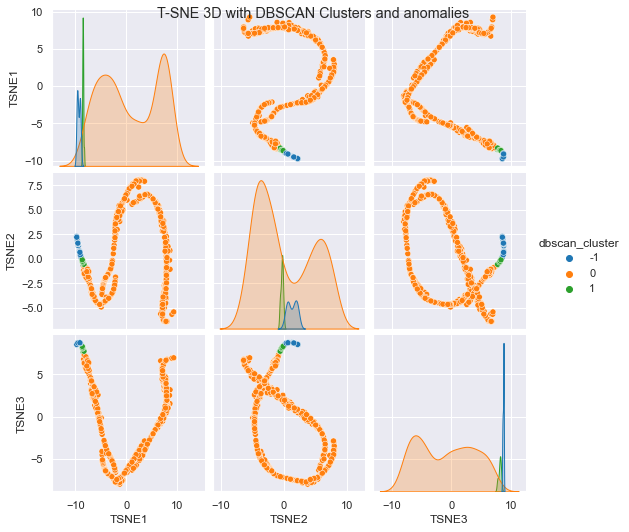

In [30]:
plot_scatter_3d_tsne_dbscan = sns.pairplot(df_tsne_3d.drop(['kmeans_cluster'], axis=1), hue='dbscan_cluster', palette='tab10')
plot_scatter_3d_tsne_dbscan.fig.suptitle("T-SNE 3D with DBSCAN Clusters and anomalies")

In [34]:
plot_2d_overview.savefig("./figs/selftrained/png/plot_2d_overview_noise")
plot_scatter_3d_tsne_dbscan.savefig("./figs/selftrained/png/plot_scatter_3d_tsne_dbscan_noise")
plot_scatter_3d_tsne_kmeans.savefig("./figs/selftrained/png/plot_scatter_3d_tsne_kmeans_noise")

plot_scatter_3d_pca_dbscan.savefig("./figs/selftrained/png/plot_scatter_3d_pca_dbscan_noise")
plot_scatter_3d_pca_kmeans.savefig("./figs/selftrained/png/plot_scatter_3d_pca_kmeans_noise")

In [32]:
pio.write_html(plot_3dscatter_3d_pca_kmeans,'./figs/selftrained/html/plot_3dscatter_3d_pca_kmeans_noise.html')
pio.write_html(plot_3dscatter_3d_pca_dbscan,'./figs/selftrained/html/plot_3dscatter_3d_pca_dbscan_noise.html')
pio.write_html(plot_3dscatter_3d_tsne_kmeans,'./figs/selftrained/html/plot_3dscatter_3d_tsne_kmeans_noise.html')
pio.write_html(plot_3dscatter_3d_tsne_dbscan,'./figs/selftrained/html/plot_3dscatter_3d_tsne_dbscan_noise.html')